In [164]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os
import matplotlib.dates as mdates

colors = ['r','r','g','g','b','b']
lines = ['--','-','--','-','--','-']

## Get Layout file

In [165]:
Layout = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='Plot')

## Get the Neutron probe and TDR data

In [166]:
NPFiles = []
TDRFiles = []
mydir = 'K:\CPDiary\Data\BaxtersMVI\Soil moisture data'
for file in os.listdir(mydir):
    if file.endswith('.NP1'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.NP2'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.TDR'):
        TDRFiles.append(os.path.join(mydir, file))

## Get all set up with indexing for experiment

In [167]:
#Set up blank dataframe to take data
ColumnLables = ['Plot','Date','D7','D6','D5','D4','D3','D2','D1']
TabIndex = pd.MultiIndex.from_arrays([[],[]],names=['Plot','Date'])
SoilWaterData = pd.DataFrame(columns=ColumnLables[2:],index = TabIndex)
#Read each file
for ObsTable in NPFiles:
    #Read in file and find which lines have legit data
    HeaderRowsToSkip = 29
    DataTab = pd.read_csv(ObsTable,skiprows = range(HeaderRowsToSkip),header=None,delim_whitespace=True)
    DataTab.dropna(inplace=True)
    DataTab.drop([0,1,3,5],axis=1,inplace=True)
    DataTab.columns = ColumnLables
    DataTab.ix[:,1] = pd.to_datetime(DataTab.ix[:,1],format='%m/%d/%y')
    SoilWaterData = SoilWaterData.append(DataTab)
SoilWaterData.ix[:,'Plot'] = np.int64(SoilWaterData.ix[:,'Plot'] )
SoilWaterData = SoilWaterData.where(SoilWaterData.ix[:,'Plot']<25).dropna()
SoilWaterData.ix[:,'Zone'] = [Layout.ix[int(x),'Zone'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Irrig'] = [Layout.ix[int(x),'Irrig'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Rep'] = [Layout.ix[int(x),'Rep'] for x in SoilWaterData.Plot]
SoilWaterData.set_index(['Plot','Date'],inplace=True,drop=False)

#Add in the TDR Data
SoilWaterData.ix[:,'D0'] = np.nan
for TDRTable in TDRFiles:
    TDRData = pd.read_csv(TDRTable,header=None).ix[:,[2,11,3]]
    TDRData.columns = ['Plot','Date','D0']
    TDRData = TDRData.drop_duplicates(subset=['Plot','Date'])
    TDRData.ix[:,'Date'] = pd.to_datetime(TDRData.ix[:,'Date'], format = '%d%b%Y')
    TDRData.set_index(['Plot','Date'],inplace=True)
    SoilWaterData.update(TDRData)
    
ObsDates = list(SoilWaterData.index.levels[1])

## Determine drained upper limit

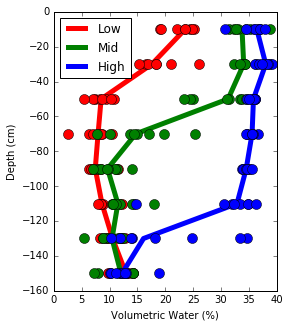

In [168]:
DUL = SoilWaterData.ix[SoilWaterData.Date=='2017-10-04',:].copy()
DUL.index = DUL.index.droplevel(1)
DULGraph, ax = plt.subplots(figsize = (4,5))
pos = 0
cols = ['r','g','b']
for ZoneID in ['Low','Mid','High']:
    ZoneFC = DUL.ix[DUL.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
    Mean = ZoneFC.median()
    plt.plot(Mean,[-10,-30,-50,-70,-90,-110,-130,-150],lw=5,color=cols[pos],label = ZoneID)
    for plot in ZoneFC.index:
        plt.plot(ZoneFC.ix[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', color = cols[pos],ms=10)
    pos += 1
plt.ylabel('Depth (cm)')
plt.xlabel('Volumetric Water (%)')
plt.legend(loc=2)

## Determine other soil parameters for all plots and depths

In [169]:
#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
#DUL must be input as mm3/mm3
def Est_SAT_from_DUL(DUL, soil_layer):
    if soil_layer <= 2:
        break_point = 30
        slope1 = 0.35
        Intercept1 = 30
        slope2 = 0.7
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.07
        Intercept1 = 30
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL <= break_point:
        Est_SAT = Intercept1 + DUL * slope1
    else:
        Est_SAT = Intercept2 + DUL * slope2
    return Est_SAT

#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
def Est_LL_from_DUL(DUL, soil_layer):
    DUL_vol = DUL
    if soil_layer <= 2:
        break_point = 25
        slope1 = 0.2522
        Intercept1 = 0 
        slope2 = 0.835
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.5
        Intercept1 = 0
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL_vol <= break_point:
        Estimate_LL_vol = Intercept1 + DUL_vol * slope1
    else:
        Estimate_LL_vol = Intercept2 + DUL_vol * slope2
    return Estimate_LL_vol

# Set up dataFrames for other parameters
LL = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
LL.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
SAT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
SAT.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
TP = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
TP.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
RT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
RT.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0

#Calculate parameter values for each depth
for plot in DUL.index:
    li = 0
    for l in ['D0','D1','D2','D3','D4','D5','D6','D7']:
        LL.loc[plot,l] = Est_LL_from_DUL(DUL.loc[plot,l],li)
        SAT.loc[plot,l] = Est_SAT_from_DUL(DUL.loc[plot,l],li)
        TP.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.5
        RT.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.9
        li +=1

### Calclculate soil profile parameters for each treatment

In [170]:
TreatIndex = pd.MultiIndex.from_product([['Low','Mid','High'],['STD','VRI']])
ProfileParams = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
Params80 = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
#All params multiplied by 2 to convert from % to mm
for treat in ProfileParams.columns:
    Filt = (SAT.Zone == treat[0]) & (SAT.Irrig == treat[1])
    ProfileParams.ix['SAT',treat] = SAT.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['SAT',treat] = SAT.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['DUL',treat] = DUL.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['DUL',treat] = DUL.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['RT',treat] = RT.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['RT',treat] = RT.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['TP',treat] = TP.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['TP',treat] = TP.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['LL',treat] = LL.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['LL',treat] = LL.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    Params80.ix['IrrigCapacity',treat] = Params80.ix['RT',treat] - Params80.ix['TP',treat]

<function matplotlib.pyplot.tight_layout>

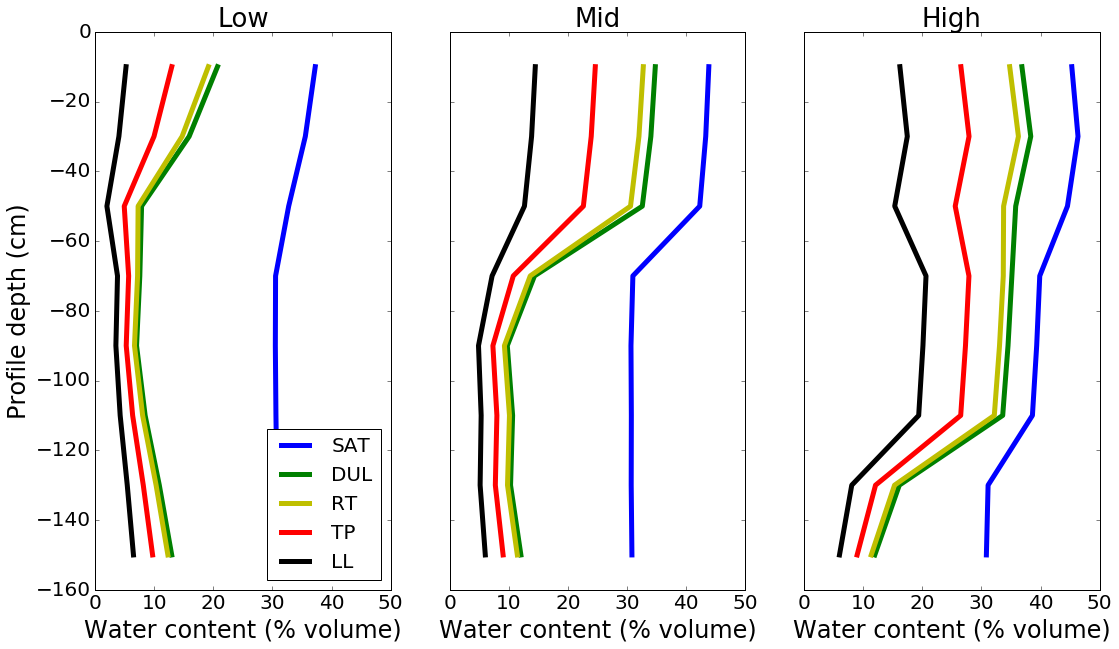

In [171]:
ProfileGraphs = plt.figure(figsize=(18,10))
axes = []
PlotPos = 1
for ZoneID in ['Low','Mid','High']:
    axes.append(ProfileGraphs.add_subplot(1,3,PlotPos))
    pos = 0
    cols = ['b','g','y','r','k']
    labs = ['SAT','DUL','RT','TP','LL']
    yloc = [-130,-140,-150]
    for Data in [SAT,DUL,RT,TP,LL]:
        Filter = (Data.Zone == ZoneID) & (Data.Irrig == 'STD')
        ParamWC = Data.ix[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
        TreatMean = ParamWC.median()
        plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],'-',color=cols[pos],lw=5,label=labs[pos])
        plt.title(ZoneID,fontsize=26)
        pos +=1
    if PlotPos in [2,3]:
        axes[PlotPos-1].tick_params(labelleft='off') 
    if PlotPos ==1:
        plt.ylabel('Profile depth (cm)',fontsize=24)
        plt.legend(loc=4,fontsize=20)
    plt.xlabel('Water content (% volume)',fontsize=24)
    plt.tick_params(labelsize=20)
    plt.xlim(0,50)
    PlotPos += 1
    
plt.tight_layout 

In [172]:
Params = ['SAT','DUL','RT','TP','LL']
for dep in SoilWaterData.sort_index(axis=1).columns[:8]:
    for Param in Params:
        ParamAndDep = Param+'_'+dep
        SoilWaterData.ix[:,ParamAndDep] = np.nan
        CurrentParam = globals()[Param]
        for plot in range(1,25):
            SoilWaterData.ix[plot,ParamAndDep] = CurrentParam.ix[plot,dep]

### Get data into a excel useful format and export

In [173]:
SoilWaterData.sort_index(axis=1,inplace=True)
SoilWaterData.set_index(['Zone','Irrig','Rep','Date','Plot'],inplace=True)
SoilWaterData.sort_index(inplace=True)
SoilWaterData.ix[:,'ProfileWater'] = [np.sum(SoilWaterData.ix[x,:][['D0','D1','D2','D3','D4','D5','D6','D7']])*2 for x in SoilWaterData.index]
SoilWaterData.to_excel('K:\CPDiary\Data\BaxtersMVI\SoilWaterRawData.xlsx',merge_cells=False,sheet_name='RawData')